In [1]:
# Importamos las libreria a utilizar
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import time
from sklearn.metrics import mean_squared_error

In [2]:
#Leemos la data
taxi = pd.read_csv('../source/taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True) 
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<Axes: xlabel='datetime'>

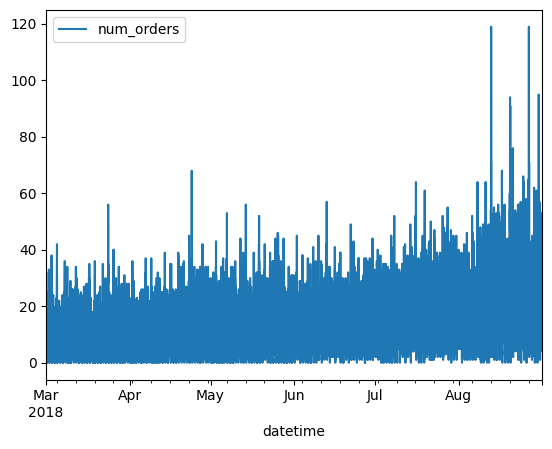

In [3]:
taxi.plot(kind='line')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8632\2945299.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  taxi_por_hora = taxi.resample('1H').sum()


<Axes: xlabel='datetime'>

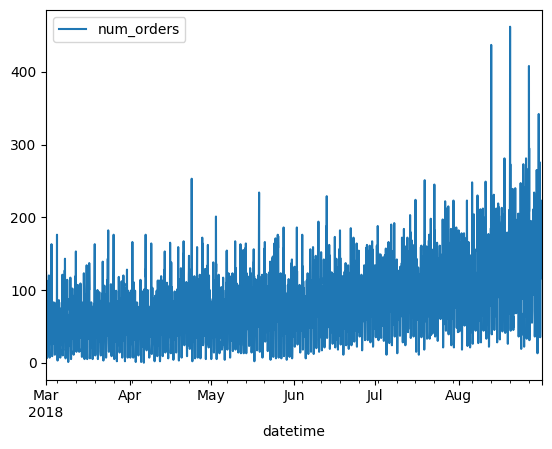

In [4]:
# Lo agrupamos por hora usando resample
taxi_por_hora = taxi.resample('1H').sum()
taxi_por_hora.plot(kind='line')

<Axes: xlabel='datetime'>

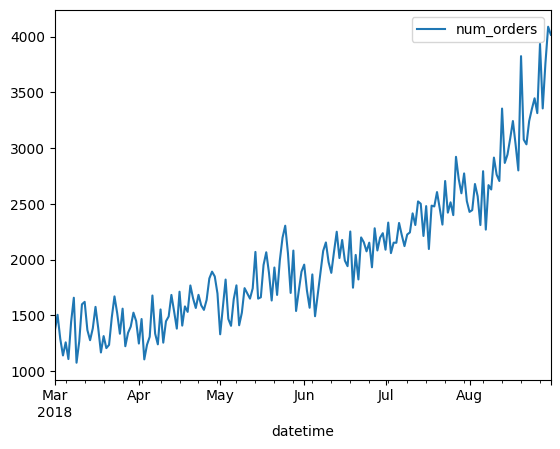

In [5]:
taxi_por_dia = taxi.resample('1D').sum()
taxi_por_dia.plot(kind='line')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8632\3491873367.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  taxi_por_mes = taxi.resample('1M').sum()


<Axes: xlabel='datetime'>

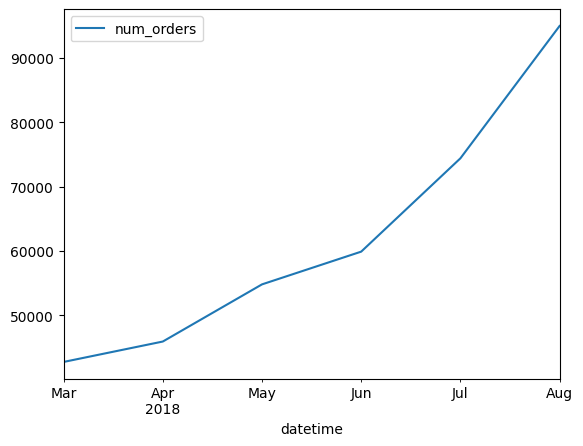

In [6]:
taxi_por_mes = taxi.resample('1M').sum()
taxi_por_mes.plot(kind='line')

Veremos la estacionalidad y la tendencia

* Estacionalidad = Es el patron que se repite durante el tiempo
* Tendencia = La tendencia es el numero de pedidos durante el tiempo, en este caso es positiva.

In [9]:
# Descomponemos la data en tendencia y estacionalidad
data_descompuesta = seasonal_decompose(taxi_por_hora)
type(data_descompuesta) # Es una variable objeto

statsmodels.tsa.seasonal.DecomposeResult

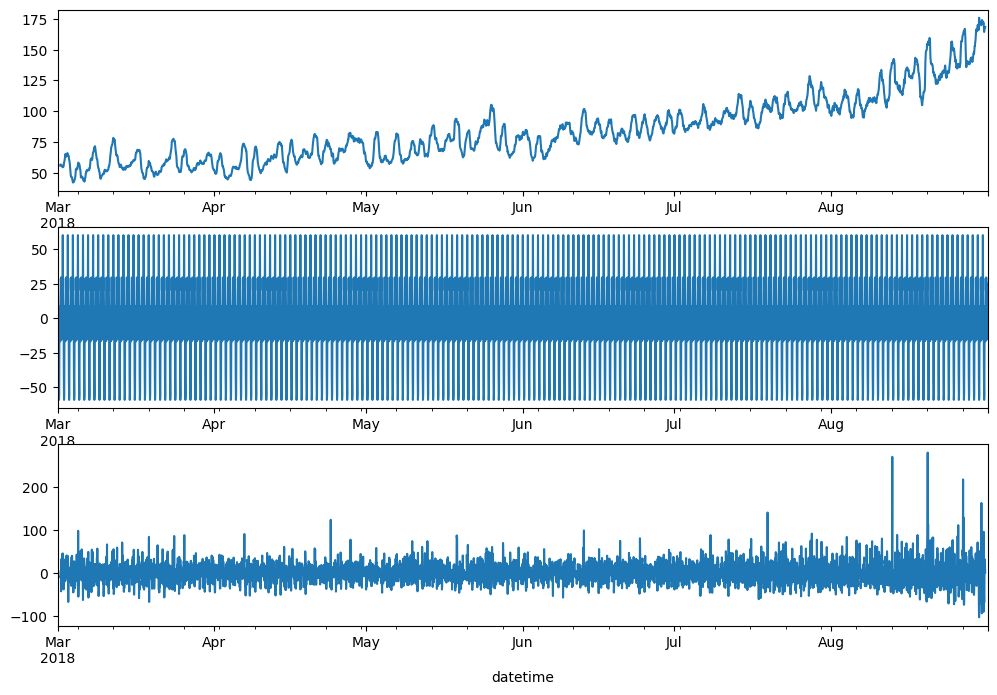

In [10]:
# Gráfico para analizar la tendencia y la estacionalidad
plt.figure(figsize=(12,8))
plt.subplot(311)
# Gráfico de la tendencia
data_descompuesta.trend.plot(ax=plt.gca())
plt.subplot(312)
# Gráfico de la estacionalidad
data_descompuesta.seasonal.plot(ax=plt.gca())
plt.subplot(313)
# Gráfico del ruido del data
data_descompuesta.resid.plot(ax=plt.gca())
plt.show()

Se puede analizar mediante la grafica que la tendencia es positiva,además, de ello se puede aprefciar que hay estacionalidades marcadas.

<Axes: xlabel='datetime'>

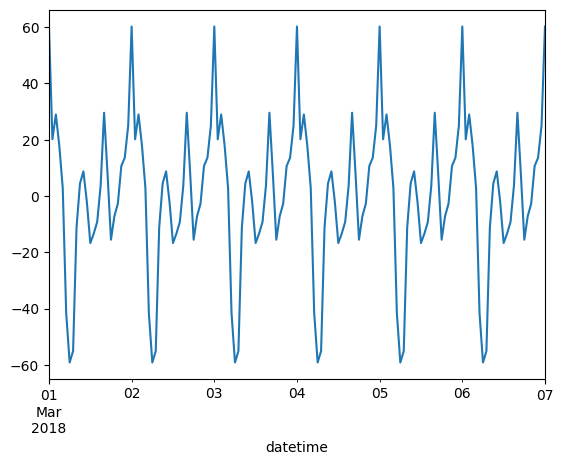

In [11]:
# Analizando la estacionalidad en siete días
data_descompuesta.seasonal[data_descompuesta.seasonal.index <='2018-03-07'].plot()

Analizando 7 días, la estacionalidad y se puede apreciar que hay patrones repetitivos para ciertas horas

In [12]:
# Agregando caracteristicas
taxi_por_hora['month'] = taxi_por_hora.index.month
taxi_por_hora['day'] = taxi_por_hora.index.day
taxi_por_hora['dia_de_la_semana'] = taxi_por_hora.index.dayofweek
taxi_por_hora['hora'] = taxi_por_hora.index.hour

In [13]:
taxi_por_hora

,num_orders,month,day,dia_de_la_semana,hora
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4
...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19
2018-08-31 20:00:00,154,8,31,4,20
2018-08-31 21:00:00,159,8,31,4,21


In [14]:
taxi_por_hora.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   num_orders        4416 non-null   int64
 1   month             4416 non-null   int32
 2   day               4416 non-null   int32
 3   dia_de_la_semana  4416 non-null   int32
 4   hora              4416 non-null   int32
dtypes: int32(4), int64(1)
memory usage: 138.0 KB


In [15]:
# Analizando 6 horas atras
for lag in range(1, 6):
    taxi_por_hora[f'lag_{lag}'] = taxi_por_hora['num_orders'].shift(lag)

In [16]:
# Hallando la media movil para suavizar las fluctuaciones
taxi_por_hora['media_movil'] = taxi_por_hora['num_orders'].rolling(3).mean()

In [18]:
taxi_por_hora.head(5)

,num_orders,month,day,dia_de_la_semana,hora,lag_1,lag_2,lag_3,lag_4,lag_5,media_movil
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,93.333333
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,74.000000
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,60.000000
